In [1]:
# Importing the Required library components

%matplotlib inline
import pymc3 as pm
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np
import theano.tensor as tt
import seaborn as sns

#### Number of People Affected Per Day ####

I obtain the count of the number of people affected per day with COVID-19 from  
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_India

The label for this count, hereafter, will be referred to as New Cases Per Day.

The Period of Data considered for the study is from 1st Apr to 17th Apr. 

In [200]:
# Representation of the Daily Cases 

daily_new_cases = np.array([437,235,478,525,505,704,508,485,591,896,768,918,905,1463,1118,826,1076])
date_arr = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

total = daily_new_cases.sum()
total_days = len(daily_new_cases)
lambda0 = daily_new_cases.mean().round(0)
print("The Number of observed Days: {}".format(total_days))
print("The average count of New Cases Per Day: {}".format(lambda0))
print("The Total number of Reported Cases: {}".format(total))

The Number of observed Days: 17
The average count of New Cases Per Day: 732.0
The Total number of Reported Cases: 12438


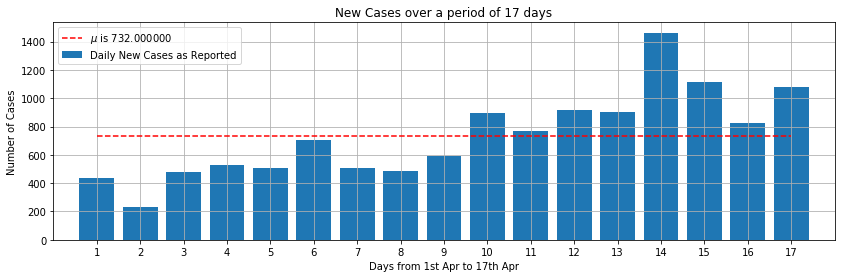

In [199]:
# Visualization of the Daily Cases

figsize(14,4)
plt.bar(date_arr,daily_new_cases,label="Daily New Cases as Reported")

plt.title("New Cases over a period of {} days".format(total_days))
plt.plot((1,total_days),(lambda0,lambda0),"r--",label="$\mu$ is %f" %lambda0)
plt.xlabel("Days from 1st Apr to 17th Apr")
plt.ylabel("Number of Cases")
plt.xlim(0,total_days+1)
plt.xticks(date_arr)

plt.legend()
plt.grid()

#### Change-Point Analysis ####

Being the data size is very small, eye-balling of the data tells us that the rate of growth from 1st to 9th looks different from that of 10th to 17th. 

However, let us validate if the given data is a mix of more than one "distribution" and where that change could potentially occur.

First, let me "quickly" address certain jargon.

##### Distribution?. 

In our context, the events are the number of people infected by the disease per day. We need a distribution to model the obtained data. 

Poisson Distribution is appropriate for modeling the number of times an event occurs in an interval of time.  

The Probability Mass Function (pmf) of Poisson Distribution is  

![alt text](poisson_pmf.png "PMF of Poisson Distribution")


λ is the average number of events in an interval.
k is the daily number of new cases (437,235,...,1076)

X ∼ Pois(λ) is the shorter version to emphasize that Poisson distribution is a Function of the Parameter Lambda.

##### Change-point?.

I mean the date at which, the characteristic of the distribution changes. 


Scenario-1

You are a developer. And hence cloud-watching your Amazon RDS may be one of our hobbies. The CPU utilization metric shows a sudden spike. You are proactive. You turn the slow-query log and identify the slow running query. Give a fix like a hero and again observe the CPU Utilization chart. You are happy upon seeing the CPU utilization is back to the "accepted normal" mark.


Scenario-2

Your supplier is very prompt for the first 100 days in a row. He is Prompt in delivering by 10:00 am. The accepted normal is 10:00 am. You see him arrive late by an hour for the last 5 days in a row.  Will you act or not? 

The Key Points are :

You are assigning importance to the latest events.

You are not complacent about the historical average.

You detect the change against an acceptable limit.

In our case we do not have an acceptable limit. I wish it to be zero.



##### Several Lambdas:

Q: What is Lamdba?
A: The Rate of New Cases Detected Per Day


Q: Can there be more than one Lambda that satisfy the PMF equation? 
Yes, we are expecting a distribution for the Lambda itself.
 
Q: And are we expecting two such distributions?
A: Yes, I'm expecting the given data is a mix of two Poisson Distribution. Hence there can be more than one Lamdba Distributions.


##### Modeling the scenario using PyMC3 - a Bayesian Modeling Framework


Now our objective is to capture the Lambdas that drive our data. 

The probabilistic design for the given context in the reverse order.

3.  The observation is X - The discrete random variables. The count of new cases per day. 

2.  X ∼ Pois(λ)  
     We will model our observation, X, with Poisson Distribution
     We need the parameter λs for that.
     
     Who can provide the λs?
     We draw samples to calculate Lambda from the Exponential Distribution.
     
1.  λ  ∼ Exp(alpha)

     We draw samples for Lambda from the Exponential Distribution.

     Exponential Distribution is to model the "amount of time until" an event occurs.
     Poisson Distribution is to model the Rate of the event.
     
     Let us call this parameter of the exponential distribution as alpha 
     
0.   So, alpha = 1/λ
     The Expected Value of a Poisson Distribution is the Average of the Events.
     EV = The average count of New Cases Per Day = 732.0
     So the prior for alpha = 1.0/732.0

Note:

We can of course, draw samples for Lambda from Gamma Distribution as well. 
Let me prove later that there is no difference between both the strategies, because Exponential Distribution is a special case of Gamma Distribution.


In [201]:
# the avg_model encompasses all the observed data

with pm.Model() as avg_model:
    alpha = 1.0/daily_new_cases.mean() # Prior.   
    lambda_for_whole = pm.Exponential("lambda_for_whole", alpha)    
    obs_whole = pm.Poisson("obs_whole",lambda_for_whole,observed=daily_new_cases)

In [202]:
# PyMC3 has the implementations of the family of Markov-Chain-Monte-Carlo algorithms. 
# NUTS is a flavor of the family of MCMC. No U-Turn Sampling.
# Let us create our own implementation of an MCMC later with RUST lang after a couple of days.

# Now do simulation to draw around 6000 samples of Lambdas.

with avg_model:
    trace_avg = pm.sample(6000,tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_for_whole]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [00:04<00:00, 7119.39draws/s]


/Users/harinimaniam/neural/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


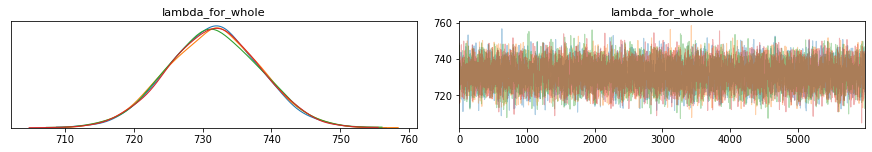

In [203]:
# Alright, MCMC Proposed a distribution of the probable lambdas for the Poisson Distribution.
# Before we proceed let us validate if the sampling process is Converged.
# Note The peaks of all the four chains of lambdas is nearer to the average 730. 

pm.traceplot(trace_avg);

In [204]:
# Convergence is confirmed by the r_hat of the parameter is 1.0
# We get certain high-level statistics about the sampling as well.

pm.summary(trace_avg)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_for_whole,731.654,6.609,719.838,744.637,0.065,0.046,10366.0,10365.0,10357.0,16526.0,1.0


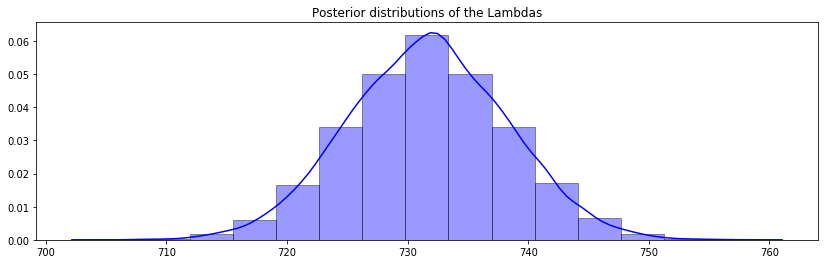

In [217]:
avg_lambdas = trace_avg["lambda_for_whole"]
plot_1 = sns.distplot(avg_lambdas, hist=True, kde=True, bins=15, color = 'blue',hist_kws={'edgecolor':'black'})
plot_1 = plot_1.set_title("Posterior distributions of the Lambdas")

#### Bayesian Vs Frequentist

1. The bayesian framework offers you a probability distribution of the Lamdba, instead of a single value.

2. Each bar of the Posterior distribution is a relative probability of the number of new cases to observe.

3. The Uncertainty is the Key to the inference.


#### Inference - 1

It is TOOOOOO early to conclude that we have around 60% of chances for any expected number of new cases.

##### Now it is time to detect the Changepoint.

Remember our key point, as decided earlier, "You are assigning importance to the latest events"

The true rate of new cases, the true lambda, is shadowed by the history.

Distilling the current distribution of lambda(s) is our immediate goal. Note the Plural - Bayesian.


In [222]:
# Obtain posterior samples from two Exponential Distributions.

# Use the switch function to randomly collect lambdas before and after a randomly selected date
# Random Ethana Random Sir!!!

# The idea is if there is no change then both the lambda distribution will be nearly identical.
# If there is a change we will end-up in collecting two lambda distributions

# We will get change-point (tau) also.

total_days = len(daily_new_cases)
with pm.Model() as cp_model:
    alpha = 1.0/daily_new_cases.mean()  
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau",lower=0,upper=total_days-1)
    
    idx = np.arange(total_days)    
    lambda_switch = pm.math.switch(tau>idx,lambda_1,lambda_2)
    
    obs_cp = pm.Poisson("obs_cp",lambda_switch,observed=daily_new_cases)

In [223]:
# Do the simulation
# Watch for the selection of NUTS for the Continuous Distribution (Exponential Distribution)
# Watch for the selection of Metropolis for Discrete Distribution (Discrete Uniform)
with cp_model:
    trace_cp = pm.sample(10000,tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6141.55draws/s]
/Users/harinimaniam/neural/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [224]:
# Time to collect the samples
lambda_1_samples = trace_cp['lambda_1']
lambda_2_samples = trace_cp['lambda_2']
tau_samples = trace_cp['tau']

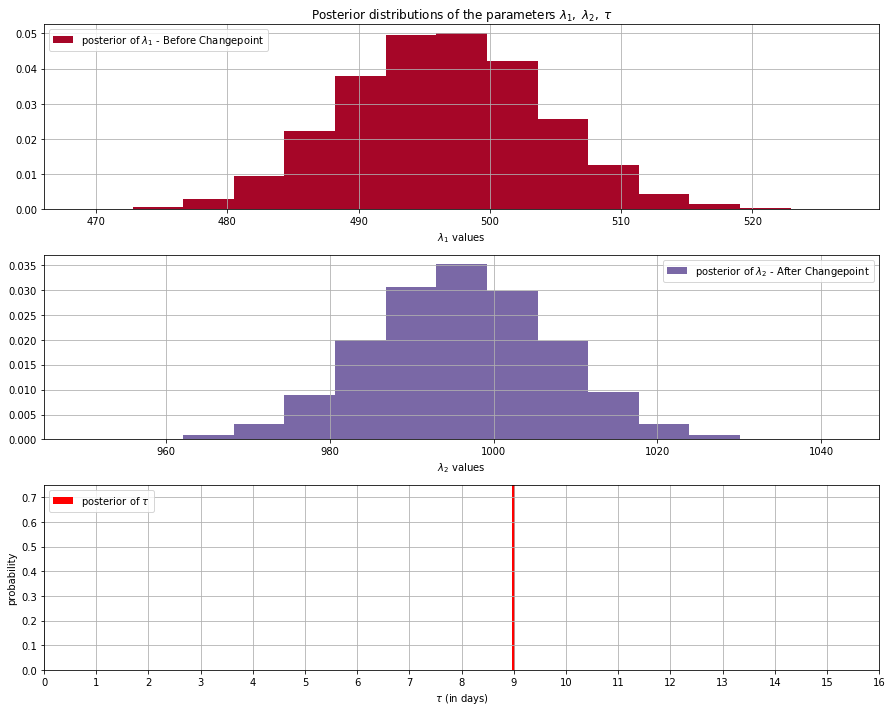

In [244]:
# Plot the Posterior Parameters lambda_1, lambda_2 and Tau as Histogram of Probability Density
# The Changepoint is tau is also a probability distribution.
# Look for potential changepoints

figsize(12.5, 10)

ax=plt.subplot(311)
plt.title(r"""Posterior distributions of the parameters $\lambda_1,\;\lambda_2,\;\tau$""")
plt.hist(lambda_1_samples, bins=15,label="posterior of $\lambda_1$ - Before Changepoint", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_1$ values")
plt.grid()

ax = plt.subplot(312)
plt.hist(lambda_2_samples, bins=15, label="posterior of $\lambda_2$ - After Changepoint", color="#7A68A6", density=True)
plt.legend(loc="upper right")
plt.xlabel("$\lambda_2$ values")
plt.grid()

ax=plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=total_days, label=r"posterior of $\tau$",color="r", weights=w )
plt.xticks(np.arange(total_days))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

plt.grid()
plt.tight_layout()

##### Change-point Detected

We have successfully separated the two distributions. 

Thanks to the hierarchical model of PyMC3 and to the many authors I referred to.

Lambda-2 is the latest trend. Which we can use to make the predictions by sampling from the Poisson Distribution.

As we have guessed already the distribution splits on the Ninth Day of April

Please wait before performing the predictions. We have a couple of activities to perform to prove our theory.



###### Box Plot the Cases of Before and After the Change-Point

We are interested in the new_cases those are on or after the changepoint. 


In [251]:
change_point_index = 9
old_cases = daily_new_cases[0:change_point_index]
new_cases = daily_new_cases[change_point_index:]
new_dates = date_arr[9:]

In [252]:
size = len(new_cases)
mean = new_cases.mean()

print("Number of New Cases {}".format(size))
print("Number of Date Array {}".format(len(new_dates)))
print("Average Number of New Cases {}".format(mean))


Number of New Cases 8
Number of Date Array 8
Average Number of New Cases 996.25


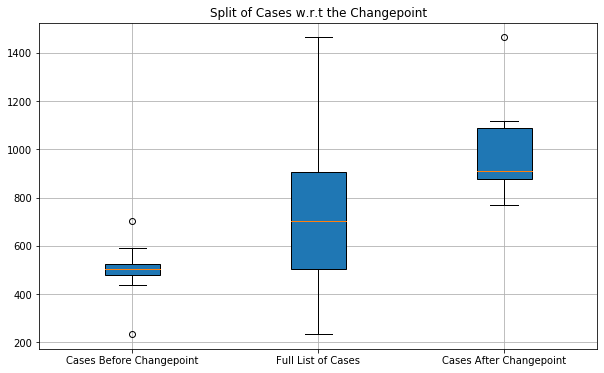

In [255]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Split of Cases w.r.t the Changepoint")
ax.boxplot([old_cases,daily_new_cases,new_cases],patch_artist=True);
ax.set_xticklabels(['Cases Before Changepoint', 'Full List of Cases', 'Cases After Changepoint']) 
plt.grid()

#### Modeling the New Cases After the Switchpoint - Gamma Distribution

Now, it is time to prove to the audience that both the Gamma distribution and Exponential Distribution are equally good to model the posterior parameter, Lambdas, of the Poisson Distribution.

The reason I've used the exponential distribution is that it requires a single hyper-parameter alpha. But the Gamma distribution requires two hyper-parameters.

However it is very interesting to define the modeling.

Again the model definition in the reverse order. 

5. The observation is X - The discrete random variables. The count of new cases per day. I   take the cases after the changepoint now.

4. A Gamma Distribution, to propose samples for the Poisson Distribution. It requires two-parameters viz., alpha and beta. I defer discussing about alpha and beta for another occasion.

3. alpha and beta are functions of two other parameters. Let us call them mu and sigma

2. Draw samples for sigma from the exponential distribution. I set the prior is 1.0

1. Draw samples for mu from another Gamma distribution. With alpha set to 1.5 and beta set to 1.0/size 


In [83]:
# The Hiarchial model definition. I call this as gamma_model

with pm.Model() as gamma_model:
    
    mu_ = pm.Gamma('mu', alpha=1.5, beta=1.0/size)
    sigma_ = pm.Exponential('sigma', 1.0)
    
    alpha_ = mu_**2/sigma_**2
    beta_ = mu_/sigma_**2
    
    lambda_ = pm.Gamma("lambda", alpha_,beta_)
    obsx = pm.Poisson("obsx",lambda_,observed=new_cases)

In [84]:
# Simulate the Gamma model
with gamma_model:
    tracex = pm.sample(5000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:07<00:00, 3239.22draws/s]


/Users/harinimaniam/neural/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/harinimaniam/neural/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/harinimaniam/neural/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


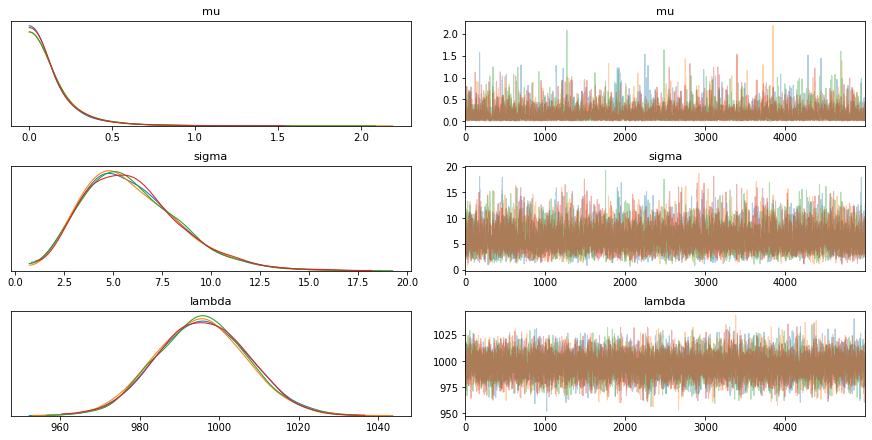

In [89]:
# Ignore the warnings.
# We are interested in the convergence of the model. Refer the RHat

pm.traceplot(tracex);

In [92]:
# Convergence is validated by R_Hat
pm.summary(tracex)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.147,0.158,0.001,0.418,0.002,0.001,7498.0,7498.0,6985.0,7625.0,1.0
sigma,5.991,2.464,1.746,10.500,0.029,0.020,7438.0,7438.0,7173.0,7687.0,1.0
lambda,995.781,11.391,974.301,1016.841,0.112,0.079,10350.0,10350.0,10353.0,10374.0,1.0


In [73]:
lambda_samples = tracex['lambda']

Posterior Lambdas collected from Gamma Distribution for the Poisson Distribution


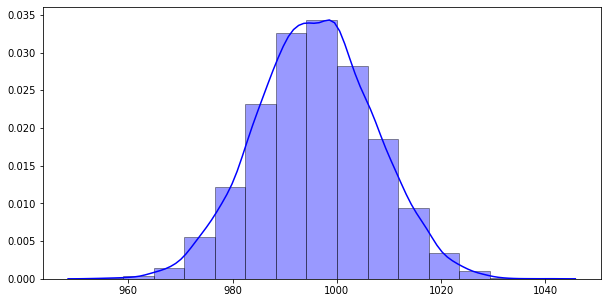

In [259]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(lambda_samples, hist=True, kde=True, bins=15, color = 'blue',hist_kws={'edgecolor':'black'})
print("Posterior Lambdas collected from Gamma Distribution for the Poisson Distribution")

##### Modeling the New Cases Post Changepoint -   Just the Exponential Distribution to propose Lambdas

This is the first exercise we did in the begining but with the entire data.
Now we are interested only in the post changepoint data.

Remember Occam's Razor. I call this model as "Simple Model". 

In [75]:
with pm.Model() as simple_model:
    alpha = 1.0/new_cases.mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    obs_simple = pm.Poisson("obs_simple",lambda_1,observed=new_cases)

In [76]:
with simple_model:
    trace_simple = pm.sample(4000,tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:02<00:00, 7392.91draws/s]


In [261]:
lambda_1_samples = trace_simple['lambda_1']

Posterior Lambdas collected from Expoential Distribution for the Poisson Distribution


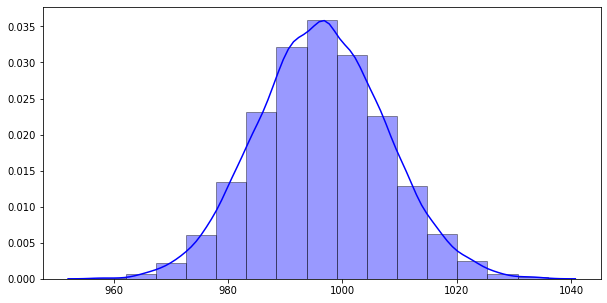

In [262]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(lambda_1_samples, hist=True, kde=True, bins=15, color = 'blue',hist_kws={'edgecolor':'black'})
print("Posterior Lambdas collected from Expoential Distribution for the Poisson Distribution")

In [79]:
pm.summary(trace_simple)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1,996.336,11.137,975.278,1017.046,0.127,0.09,7641.0,7641.0,7645.0,11139.0,1.0


In [80]:
pm.summary(tracex)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.145,0.160,0.002,0.407,0.002,0.001,7650.0,7650.0,6919.0,8453.0,1.0
sigma,5.964,2.458,1.845,10.518,0.029,0.021,7100.0,7100.0,6691.0,7880.0,1.0
lambda,995.887,11.263,974.836,1017.174,0.117,0.083,9196.0,9196.0,9167.0,10044.0,1.0


#### Inference

Now we have the posterior parameters for the Poisson Distributed Daily New Cases after the Switch Point.

So, we are ready to answer certain questions using the lambdas that we have collected.

Q: What is the expected number of new cases given the current context?

The bayesian answer will be again a distribution as captured below. 

The Probability of daily new new cases


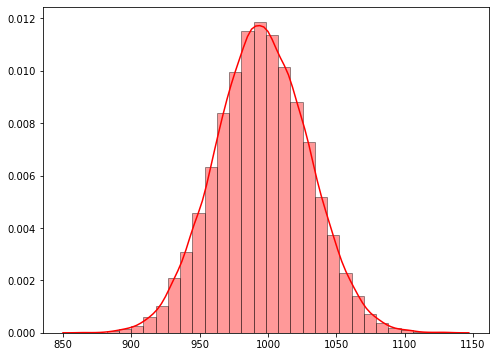

In [263]:
future = np.random.poisson(lam=tracex['lambda'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_pred, color="red", bins=30, ax=ax,hist_kws={'edgecolor':'black'})
print("The Probability of daily new new cases")

Okay. We understand. There is no single answer. 

How many cases we can expect between 900 to 1000 ?

In [271]:
def how_many(future,start,end):
    count = 0
    for x in future:
        if(x>= start and x<= end):
            count+=1
    return count/len(future)


print("Probability of daily new cases between 900 and 1000 : {}".format(how_many(future,900,1000)))
print("Probability of daily new cases between 1000 and 1200 : {}".format(how_many(future,1000,1200)))

less_than_900 = (future < 900).astype(int).mean()
less_than_1000 = (future < 1000).astype(int).mean()
above_1200 = (future > 1200).astype(int).mean()

print("Probability of daily news cases less than 900 : {}".format(less_than_900))
print("Probability of daily news cases less than 900 : {}".format(less_than_1000))

print("Probability of daily news cases above 1200 : {}".format(above_1200))


Probability of daily new cases between 900 and 1000 : 0.5647
Probability of daily new cases between 1000 and 1200 : 0.4448
Probability of daily news cases less than 900 : 0.0016
Probability of daily news cases less than 900 : 0.5552
Probability of daily news cases above 1200 : 0.0


#### Good News & ...

We have more than 50% chances for the number of cases to reduce to less than 900.

Having said that, we have experienced a changepoint where the rates are pretty high.

Social Distancing is the only option to help to break the chain of transmission or to reduce the  

எதிரதாக் காக்கும் அறிவினார்க் கில்லை
அதிர வருவதோர் நோய்.

No terrifying calamity will affect the wise, who foresee and guard against evils.

Thanks

